In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sb
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer
import string


import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer

# 1.Data Processing and Analysis

In [2]:
data = pd.read_csv("/Users/nataliechang/Desktop/Eluvio_DS_Challenge.csv")

In [3]:
data = data.drop(columns=['down_votes','category'])

class_mapping = {label: idx for idx, label in enumerate(np.unique(data['over_18']))}
data['over_18'] = data['over_18'].map(class_mapping)
class_mapping2 = {label: idx for idx, label in enumerate(np.unique(data['author']))}
data['author'] = data['author'].map(class_mapping2)

data['date_created'] = data['date_created'].map(lambda x: x.replace('-',''))
data.head()

,time_created,date_created,up_votes,title,over_18,author
0,1201232046,20080125,3,Scores killed in Pakistan clashes,0,69315
1,1201232075,20080125,2,Japan resumes refuelling mission,0,69315
2,1201232523,20080125,3,US presses Egypt on Gaza border,0,69315
3,1201233290,20080125,1,Jump-start economy: Give health care to all,0,47884
4,1201274720,20080125,4,Council of Europe bashes EU&UN terror blacklist,0,62766


#  Top 10 title Tokenized

In [4]:
stopwords = set(stopwords.words('english'))
top_titles = data.sort_values(by='up_votes', ascending=False)['title'].values[:10]
top_words = set(np.concatenate([word_tokenize(t) for t in top_titles])) - stopwords
top_words = {word.lower() for word in top_words}
top_words = top_words - set(string.punctuation) - set(string.digits)

# Add Tokenized data

In [5]:
words_tokenized = [[w.lower() for w in word_tokenize(t)] for t in data['title']]
data['tokenized_title'] = words_tokenized
all_words = pd.Series(np.concatenate(words_tokenized)).value_counts()

In [6]:
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]

In [7]:
stemmer = PorterStemmer()
all_words.index = [stemmer.stem(w) for w in all_words.index]

<AxesSubplot:>

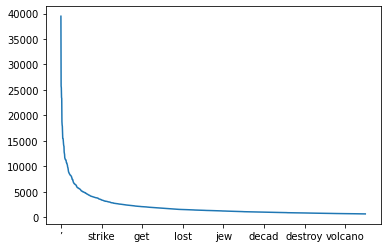

In [8]:
all_words[:1500].plot()

In [9]:
all_stems = all_words.groupby(by=all_words.index).sum().sort_values(ascending=False)
data['stemmed_title'] = data['tokenized_title'].map(lambda wl: [stemmer.stem(w) for w in wl])

In [10]:
pos_tag(data['tokenized_title'][0])
data['pos_title'] = data['tokenized_title'].map(lambda t: [t[1] for t in pos_tag(t)])
data['pos_title'].head()

0                   [NNS, VBN, IN, NN, NNS]
1                        [NN, VBZ, VBG, NN]
2                [PRP, VBZ, NN, IN, NN, NN]
3           [JJ, NN, :, JJ, NN, NN, TO, DT]
4    [NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]
Name: pos_title, dtype: object

In [11]:
def noun(df):
    tags = df['pos_title']
    stems = df['stemmed_title']
    return [s for (t, s) in zip(tags, stems) if t in ['NN', 'NNS']]

In [12]:
data['main_title'] = data.apply(noun, axis='columns')

In [13]:
title_counts = pd.Series(np.concatenate(data['main_title'].values)).value_counts()
title_counts[1:].head(10)

china     21660
attack    18450
world     17999
year      16583
govern    16199
state     16054
polic     15917
syria     15904
russia    15620
presid    15263
dtype: int64

<AxesSubplot:>

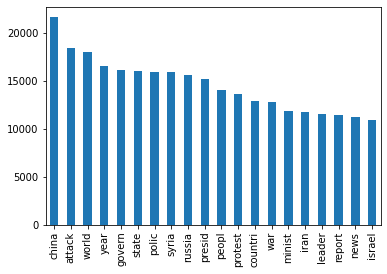

In [14]:
title_counts[1:].head(20).plot(kind='bar')

In [15]:
title_list = data['title']
sa = SentimentIntensityAnalyzer()
sentiment = [sa.polarity_scores(t)['compound'] for t in title_list]

In [16]:
sentiment = np.asarray(sentiment)

for i in range(sentiment.size):
    if (sentiment[i] >= 0):
        sentiment[i] = 1 
    else:
        sentiment[i] = 0 

data['sentiment'] = sentiment

In [17]:
data.head()

,time_created,date_created,up_votes,title,over_18,author,tokenized_title,stemmed_title,pos_title,main_title,sentiment
0,1201232046,20080125,3,Scores killed in Pakistan clashes,0,69315,"[scores, killed, in, pakistan, clashes]","[score, kill, in, pakistan, clash]","[NNS, VBN, IN, NN, NNS]","[score, pakistan, clash]",0.0
1,1201232075,20080125,2,Japan resumes refuelling mission,0,69315,"[japan, resumes, refuelling, mission]","[japan, resum, refuel, mission]","[NN, VBZ, VBG, NN]","[japan, mission]",1.0
2,1201232523,20080125,3,US presses Egypt on Gaza border,0,69315,"[us, presses, egypt, on, gaza, border]","[us, press, egypt, on, gaza, border]","[PRP, VBZ, NN, IN, NN, NN]","[egypt, gaza, border]",1.0
3,1201233290,20080125,1,Jump-start economy: Give health care to all,0,47884,"[jump-start, economy, :, give, health, care, t...","[jump-start, economi, :, give, health, care, t...","[JJ, NN, :, JJ, NN, NN, TO, DT]","[economi, health, care]",1.0
4,1201274720,20080125,4,Council of Europe bashes EU&UN terror blacklist,0,62766,"[council, of, europe, bashes, eu, &, un, terro...","[council, of, europ, bash, eu, &, un, terror, ...","[NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]","[council, europ, bash, terror, blacklist]",0.0


In [18]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data['tokenized_title'])
sequences = tokenizer_obj.texts_to_sequences(data['tokenized_title'])
word_index = tokenizer_obj.word_index

#pad sequences
max_length = max([len(t.split()) for t in data['title']])
title_pad = pad_sequences(sequences, maxlen = max_length)

print("Shape of title tensor",title_pad.shape)
print("Shape of sentiment tensor",data['sentiment'].shape)

Shape of title tensor (509236, 64)
Shape of sentiment tensor (509236,)


# Predict sentiment

In [19]:
X_train = title_pad
indices = np.arange(title_pad.shape[0])
y_train = data['sentiment'][indices]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# LogisticRegression

In [20]:
LR = LogisticRegression(C=1.0, tol=0.01)
LR.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(tol=0.01)

In [21]:
y_predict = LR.predict(X_val)
LR.score(X_val, y_val)

0.5224059382609378

In [22]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.60      0.30      0.40     53826
         1.0       0.50      0.77      0.60     48022

    accuracy                           0.52    101848
   macro avg       0.55      0.54      0.50    101848
weighted avg       0.55      0.52      0.50    101848



# GBDT

In [23]:
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)

GradientBoostingClassifier()

In [24]:
y_predict = gbdt.predict(X_val)
gbdt.score(X_val, y_val)

0.5963494619432881

In [25]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.59      0.75      0.66     53826
         1.0       0.60      0.43      0.50     48022

    accuracy                           0.60    101848
   macro avg       0.60      0.59      0.58    101848
weighted avg       0.60      0.60      0.59    101848



# Multi-layer Neural network

In [26]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 2), random_state=1)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(8, 2), random_state=1,
              solver='lbfgs')

In [27]:
y_predict = mlp.predict(X_val)
mlp.score(X_val, y_val)

0.5284934412065038

In [28]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69     53826
         1.0       0.00      0.00      0.00     48022

    accuracy                           0.53    101848
   macro avg       0.26      0.50      0.35    101848
weighted avg       0.28      0.53      0.37    101848



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LightGBM

In [29]:
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from lightgbm import LGBMClassifier
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=500, learning_rate=0.001, 
                                    max_depth=800, feature_fraction=0.8, subsample=0.2,
                                    is_unbalance=True)
lgb_classifier.fit(X_train,y_train)
y_head = lgb_classifier.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [31]:
y_head = y_head.tolist()

In [32]:
print(classification_report(y_head, y_val))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69    101528
         1.0       0.01      0.85      0.01       320

    accuracy                           0.53    101848
   macro avg       0.50      0.69      0.35    101848
weighted avg       1.00      0.53      0.69    101848

